In [2]:
import pandas as pd
import numpy as np

def engineer_basic_chocolate_features(df):
    """
    Compute basic engineered features for chocolate formulations dataset
    These are composition-based, nutritional, and categorical features that can be calculated immediately.
    
    Parameters:
    df (pandas.DataFrame): Original formulations dataset
    
    Returns:
    pandas.DataFrame: Enhanced dataset with basic engineered features
    """
    
    # Create a copy to avoid modifying original data
    enhanced_df = df.copy()
    
    # Helper function for safe calculations (handle NaN/None values)
    def safe_divide(numerator, denominator, default=0):
        """Safe division that handles zero denominators and NaN values"""
        try:
            result = numerator / denominator if denominator != 0 else default
            return result if not np.isnan(result) else default
        except:
            return default
    
    def safe_value(value, default=0):
        """Safe value extraction that handles NaN/None"""
        # try:
        #     return value if not pd.isna(value) else default
        # except:
        #     return default
        return value
    
    print("Computing basic engineered features...")
    
    # =================================================================
    # A. INGREDIENT-BASED ENGINEERED FEATURES
    # =================================================================
    
    print("1. Computing ingredient-based features...")
    
    # Total cocoa content (cocoa beans + cocoa butter)
    enhanced_df['total_cocoa_pct'] = (
        safe_value(enhanced_df['cocoa_beans'], 0) + 
        safe_value(enhanced_df['cocoa_butter'], 0)
    )
    
    # Milk to sugar ratio (key texture predictor)
    enhanced_df['milk_sugar_ratio'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row['whole_milk_powder'], 0), 
            safe_value(row['beetroot_sugar'], 1)
        ), axis=1
    )
    
    # Total flavor intensity (vanilla + natural flavors)
    enhanced_df['flavor_intensity'] = (
        safe_value(enhanced_df['artificial_vanilla_aroma'], 0) +
        safe_value(enhanced_df['natural_vanilla_aroma'], 0) +
        safe_value(enhanced_df['natural_flavor'], 0)
    )
    
    # =================================================================
    # B. NUTRITIONAL-BASED ENGINEERED FEATURES  
    # =================================================================
    
    print("2. Computing nutritional-based features...")
    
    # Unsaturated fat content
    enhanced_df['unsaturated_fat_pct'] = (
        safe_value(enhanced_df['fat'], 0) - 
        safe_value(enhanced_df['SFA'], 0)
    )
    
    # Fat quality index (ratio of saturated to total fat)
    enhanced_df['fat_quality_index'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row['SFA'], 0), 
            safe_value(row['fat'], 1)
        ), axis=1
    )
    
    # Sweetness ratio (sugar relative to sugar + cocoa)
    enhanced_df['sweetness_ratio'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row['beetroot_sugar'], 0), 
            safe_value(row['beetroot_sugar'], 0) + safe_value(row['total_cocoa_pct'], 1)
        ), axis=1
    )
    
    # =================================================================
    # C. CATEGORICAL/CLASSIFICATION FEATURES
    # =================================================================
    
    print("3. Computing categorical features...")
    
    # Classic milk identification
    enhanced_df['is_classic_milk'] = enhanced_df['Flavor'].apply(
        lambda x: 1 if str(x).strip() == 'Classic Milk' else 0
    )
    
    # Fruit flavor identification
    fruit_flavors = ['Mango', 'Cherry', 'Blackberry', 'Strawberry', 'Orange', 'Passion Fruit']
    enhanced_df['is_fruit_flavor'] = enhanced_df['Flavor'].apply(
        lambda x: 1 if str(x).strip() in fruit_flavors else 0
    )
    
    # Flavor complexity (has natural flavors)
    enhanced_df['flavor_complexity'] = enhanced_df['natural_flavor'].apply(
        lambda x: 1 if safe_value(x, 0) > 0 else 0
    )
    
    # Formulation type
    enhanced_df['formulation_type'] = enhanced_df['Flavor'].apply(
        lambda x: 'Classic' if str(x).strip() == 'Classic Milk' else 'Flavored'
    )
    
    # =================================================================
    # D. ADVANCED DERIVED FEATURES
    # =================================================================
    
    print("4. Computing advanced derived features...")
    
    # Cocoa intensity (normalized)
    enhanced_df['cocoa_intensity'] = enhanced_df['total_cocoa_pct'] / 100.0
    
    # Estimated dairy content (milk powder + protein equivalent)
    enhanced_df['dairy_content'] = (
        safe_value(enhanced_df['whole_milk_powder'], 0) + 
        safe_value(enhanced_df['protein'], 0) * 2  # Protein factor approximation
    )
    
    # Premium score (cocoa quality + natural ingredients)
    enhanced_df['premium_score'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['total_cocoa_pct'], 0) + 
            safe_value(row['natural_flavor'], 0) * 100 + 
            safe_value(row['natural_vanilla_aroma'], 0) * 100
        ) / 50.0, axis=1
    )
    
    # =================================================================
    # E. PROCESSING/TEXTURE PREDICTION HELPERS
    # =================================================================
    
    print("5. Computing processing prediction features...")
    
    # Expected hardness index (based on fat and sugar content)
    enhanced_df['expected_hardness_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['beetroot_sugar'], 0) * 0.4 + 
            safe_value(row['SFA'], 0) * 0.6
        ) / 100.0, axis=1
    )
    
    # Processing difficulty score
    enhanced_df['processing_difficulty'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row['protein'], 0) + safe_value(row['whole_milk_powder'], 0) * 0.2,
            safe_value(row['fat'], 1)
        ), axis=1
    )
    
    # Melting prediction index (based on fat composition)
    enhanced_df['melting_prediction_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['cocoa_butter'], 0) * 0.7 + 
            safe_value(row['SFA'], 0) * 0.3
        ) / 100.0, axis=1
    )
    
    # =================================================================
    # F. INTERACTION FEATURES
    # =================================================================
    
    print("6. Computing interaction features...")
    
    # Sweet-creamy balance
    enhanced_df['sweet_creamy_balance'] = enhanced_df.apply(
        lambda row: safe_value(row['milk_sugar_ratio'], 0) * safe_value(row['sweetness_ratio'], 0), 
        axis=1
    )
    
    # Cocoa-dairy interaction
    enhanced_df['cocoa_dairy_interaction'] = enhanced_df.apply(
        lambda row: safe_value(row['total_cocoa_pct'], 0) * safe_value(row['dairy_content'], 0) / 1000.0, 
        axis=1
    )
    
    # Flavor-quality interaction
    enhanced_df['flavor_quality_interaction'] = enhanced_df.apply(
        lambda row: safe_value(row['flavor_intensity'], 0) * safe_value(row['premium_score'], 0) * 10, 
        axis=1
    )
    
    print("Basic feature engineering completed!")
    print(f"New basic features added: {enhanced_df.shape[1] - df.shape[1]}")
    
    return enhanced_df

def engineer_shelf_life_features(df):
    """
    Add Phase 1 engineered features for shelf life prediction to the chocolate formulations dataset
    These are stability-focused features that predict degradation and shelf life.
    
    Parameters:
    df (pandas.DataFrame): Dataset with basic engineered features already computed
    
    Returns:
    pandas.DataFrame: Enhanced dataset with Phase 1 shelf life features
    """
    
    # Create a copy to avoid modifying original data
    enhanced_df = df.copy()
    
    # Helper function for safe calculations
    def safe_divide(numerator, denominator, default=0):
        try:
            result = numerator / denominator if denominator != 0 else default
            return result if not np.isnan(result) else default
        except:
            return default
    
    def safe_value(value, default=0):
        try:
            return value if not pd.isna(value) else default
        except:
            return default
    
    print("Adding Phase 1 Shelf Life Engineered Features...")
    
    # ================================================================
    # PHASE 1 FEATURE 1: OXIDATION SUSCEPTIBILITY INDICES (CRITICAL)
    # ================================================================
    
    print("1. Computing oxidation susceptibility features...")
    
    # Processing intensity factor (normalized) - using defaults if processing params not available
    enhanced_df['processing_intensity_factor'] = enhanced_df.apply(
        lambda row: (
            (safe_value(row.get('conching_temperature_c', 75), 75) - 60) * 
            safe_value(row.get('conching_time_min', 180), 180)
        ) / 10000, axis=1  # Normalized to 0-15 range
    )
    
    # Fat oxidation vulnerability - strongest shelf life predictor
    enhanced_df['oxidation_risk_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['unsaturated_fat_pct'], 0) / 
            (safe_value(row['fat_quality_index'], 0.6) + 0.01)
        ) * (1 + safe_value(row['processing_intensity_factor'], 0.5)), axis=1
    )
    
    # Fat stability score (higher = more stable)
    enhanced_df['fat_stability_score'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row['SFA'], 0), 
            safe_value(row['unsaturated_fat_pct'], 1) + 0.01
        ), axis=1
    )
    
    # Thermal stress index during processing
    enhanced_df['thermal_stress_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row.get('conching_temperature_c', 75), 75) * 
            safe_value(row.get('conching_time_min', 180), 180)
        ) / (safe_value(row['fat_quality_index'], 0.6) * 10000), axis=1  # Normalized
    )
    
    # ================================================================
    # PHASE 1 FEATURE 2: MOISTURE ACTIVITY PREDICTORS (HIGH IMPACT)
    # ================================================================
    
    print("2. Computing moisture activity predictors...")
    
    # Water activity estimation from composition
    enhanced_df['moisture_risk_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['dairy_content'], 0) * 0.4 + 
            safe_value(row['Total_sugars'], 0) * 0.3 + 
            safe_value(row['protein'], 0) * 0.3
        ) / 10, axis=1  # Normalized to 0-20 range
    )
    
    # Hygroscopic ingredient score (attracts moisture)
    enhanced_df['hygroscopic_ingredient_score'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['beetroot_sugar'], 0) + 
            safe_value(row['whole_milk_powder'], 0) + 
            safe_value(row['soy_lecithin'], 0) * 10  # Lecithin is highly hygroscopic
        ), axis=1
    )
    
    # Water binding capacity
    enhanced_df['water_binding_capacity'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['protein'], 0) * 4 + 
            safe_value(row['Total_sugars'], 0) * 0.8
        ), axis=1  # Protein binds 4x more water than sugar
    )
    
    # ================================================================
    # PHASE 1 FEATURE 3: CRYSTAL STRUCTURE STABILITY (MEDIUM-HIGH IMPACT)
    # ================================================================
    
    print("3. Computing crystal structure stability features...")
    
    # Fat bloom susceptibility
    enhanced_df['bloom_susceptibility'] = enhanced_df.apply(
        lambda row: (
            safe_divide(safe_value(row['cocoa_butter'], 0), safe_value(row['fat'], 1) + 0.01)
        ) * (1 - safe_value(row['fat_quality_index'], 0.6)) * 10, axis=1  # Higher = more susceptible
    )
    
    # Fat migration risk (incompatible fats)
    enhanced_df['fat_migration_risk'] = enhanced_df.apply(
        lambda row: safe_divide(
            safe_value(row.get('palm_oil', 0), 0), 
            safe_value(row['cocoa_butter'], 1) + 0.01
        ) * 5, axis=1  # Normalized
    )
    
    # Crystal stability index (higher = more stable)
    tempering_quality_proxy = 1.0  # Assume standard tempering for all samples
    enhanced_df['crystal_stability_index'] = enhanced_df.apply(
        lambda row: (
            tempering_quality_proxy * safe_value(row.get('cooling_rate_c_per_min', 2.0), 2.0)
        ) / (1 + safe_value(row['fat_migration_risk'], 0)), axis=1
    )
    
    # ================================================================
    # PHASE 1 FEATURE 4: CHEMICAL REACTIVITY INDICES (MEDIUM IMPACT)
    # ================================================================
    
    print("4. Computing chemical reactivity indices...")
    
    # Maillard reaction potential (browning, off-flavors)
    enhanced_df['maillard_risk'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['protein'], 0) * safe_value(row['Total_sugars'], 0)
        ) / 100, axis=1  # Normalized
    )
    
    # Amino-sugar interaction potential
    enhanced_df['amino_sugar_interaction'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['whole_milk_powder'], 0) * safe_value(row['beetroot_sugar'], 0)
        ) / 100, axis=1
    )
    
    # Browning potential index
    enhanced_df['browning_potential'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['protein'], 0) * 0.6 + 
            safe_value(row['Total_sugars'], 0) * 0.4
        ) / 10, axis=1  # Normalized
    )
    
    # ================================================================
    # PHASE 1 FEATURE 5: PROCESSING STRESS ACCUMULATION (MEDIUM IMPACT)
    # ================================================================
    
    print("5. Computing processing stress features...")
    
    # Thermal damage index
    enhanced_df['thermal_damage_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row.get('conching_temperature_c', 75), 75) * 
            safe_value(row.get('conching_time_min', 180), 180) * 
            safe_value(row.get('grinding_fineness_micron', 20), 20)
        ) / 1000000, axis=1  # Normalized
    )
    
    # Mechanical stress accumulation
    enhanced_df['mechanical_stress'] = enhanced_df.apply(
        lambda row: (
            safe_value(row.get('mixing_speed_rpm', 30), 30) * 
            safe_value(row.get('refining_passes', 3), 3) * 
            safe_value(row.get('conching_time_min', 180), 180)
        ) / 10000, axis=1  # Normalized
    )
    
    # Process severity score
    enhanced_df['process_severity_score'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['thermal_damage_index'], 0) + safe_value(row['mechanical_stress'], 0)
        ) / 2, axis=1
    )
    
    # ================================================================
    # PHASE 1 FEATURE 6: COMPOSITE INDICES (HIGHEST IMPACT)
    # ================================================================
    
    print("6. Computing composite stability indices...")
    
    # Composite stability index - weighted combination of top risk factors
    enhanced_df['composite_stability_index'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['oxidation_risk_index'], 0) * 0.4 +          # Highest weight
            safe_value(row['moisture_risk_index'], 0) * 0.3 +           # Second weight
            safe_value(row['bloom_susceptibility'], 0) * 0.2 +          # Third weight  
            safe_value(row['process_severity_score'], 0) * 0.1          # Fourth weight
        ), axis=1
    )
    
    # Overall stability score (inverted - higher = more stable)
    enhanced_df['overall_stability_score'] = enhanced_df.apply(
        lambda row: 100 / (safe_value(row['composite_stability_index'], 1) + 1), axis=1
    )
    
    # ================================================================
    # PHASE 1 FEATURE 7: PROTECTIVE FACTORS (STABILITY ENHANCERS)
    # ================================================================
    
    print("7. Computing protective factors...")
    
    # Natural antioxidant content (protective)
    enhanced_df['antioxidant_protection'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['cocoa_beans'], 0) * 0.8 +           # Cocoa has natural antioxidants
            safe_value(row['natural_flavor'], 0) * 20 +         # Natural flavors often have antioxidants
            safe_value(row['natural_vanilla_aroma'], 0) * 20    # Vanilla has antioxidant properties
        ), axis=1
    )
    
    # Fat crystal protection (pure cocoa butter is most stable)
    enhanced_df['fat_crystal_protection'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['cocoa_butter'], 0) / 
            (safe_value(row['cocoa_butter'], 0) + safe_value(row.get('palm_oil', 0), 0) + 0.01)
        ) * 10, axis=1
    )
    
    # Emulsifier stabilization effect
    enhanced_df['emulsifier_stabilization'] = enhanced_df.apply(
        lambda row: safe_value(row['soy_lecithin'], 0) * 20, axis=1  # Lecithin protects fat-water interfaces
    )
    
    # Combined protective effect
    enhanced_df['total_protective_effect'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['antioxidant_protection'], 0) + 
            safe_value(row['fat_crystal_protection'], 0) + 
            safe_value(row['emulsifier_stabilization'], 0)
        ) / 3, axis=1
    )
    
    # ================================================================
    # PHASE 1 FEATURE 8: FAILURE MODE PREDICTORS (TARGETED)
    # ================================================================
    
    print("8. Computing failure mode predictors...")
    
    # Fat bloom predictor (specific to visual defects)
    enhanced_df['fat_bloom_predictor'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['bloom_susceptibility'], 0) * 
            (1 + safe_value(row['thermal_stress_index'], 0)) *
            (1 - safe_value(row['fat_crystal_protection'], 0) / 10)
        ), axis=1
    )
    
    # Color degradation predictor (browning/fading)
    enhanced_df['color_degradation_predictor'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['maillard_risk'], 0) * 
            (1 + safe_value(row['processing_intensity_factor'], 0))
        ), axis=1
    )
    
    # Texture failure predictor (hardening/softening)
    enhanced_df['texture_failure_predictor'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['moisture_risk_index'], 0) * 
            safe_value(row['hygroscopic_ingredient_score'], 0) / 10
        ), axis=1
    )
    
    # Flavor degradation predictor (rancidity/off-flavors)
    enhanced_df['flavor_degradation_predictor'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['oxidation_risk_index'], 0) * 
            (1 - safe_value(row['antioxidant_protection'], 0) / 50)
        ), axis=1
    )
    
    # ================================================================
    # PHASE 1 FEATURE 9: INTERACTION TERMS (SYNERGISTIC EFFECTS)
    # ================================================================
    
    print("9. Computing interaction terms...")
    
    # Moisture-fat interaction (amplifies degradation)
    enhanced_df['moisture_fat_interaction'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['moisture_risk_index'], 0) * safe_value(row['oxidation_risk_index'], 0)
        ) / 10, axis=1
    )
    
    # Temperature-composition interaction
    enhanced_df['temperature_composition_interaction'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['process_severity_score'], 0) * 
            (safe_value(row['fat_migration_risk'], 0) + safe_value(row['maillard_risk'], 0))
        ), axis=1
    )
    
    # Protein-sugar browning interaction
    enhanced_df['protein_sugar_browning'] = enhanced_df.apply(
        lambda row: (
            safe_value(row['protein'], 0) * safe_value(row['Total_sugars'], 0) * 
            safe_value(row['thermal_stress_index'], 0)
        ) / 100, axis=1
    )
    
    # ================================================================
    # SUMMARY STATISTICS AND VALIDATION
    # ================================================================
    
    print("10. Computing summary statistics...")
    
    # Count of new features added
    new_features = [col for col in enhanced_df.columns if col not in df.columns]
    
    print(f"Phase 1 Shelf Life Feature Engineering Complete!")
    print(f"Original features: {len(df.columns)}")
    print(f"New shelf life features added: {len(new_features)}")
    print(f"Total features: {len(enhanced_df.columns)}")
    
    # Display feature ranges for validation
    print(f"Key Feature Ranges:")
    key_features = [
        'oxidation_risk_index', 'moisture_risk_index', 'bloom_susceptibility', 
        'composite_stability_index', 'overall_stability_score'
    ]
    
    for feature in key_features:
        min_val = enhanced_df[feature].min()
        max_val = enhanced_df[feature].max()
        mean_val = enhanced_df[feature].mean()
        print(f"{feature}: {min_val:.3f} - {max_val:.3f} (mean: {mean_val:.3f})")
    
    return enhanced_df

# =================================================================
# MAIN PROCESSING FUNCTION
# =================================================================

def process_complete_feature_engineering(df):
    """
    Complete feature engineering pipeline combining basic and shelf life features
    
    Parameters:
    df (pandas.DataFrame): Original formulations dataset
    
    Returns:
    pandas.DataFrame: Fully enhanced dataset with all engineered features
    """
    
    print("COMPLETE CHOCOLATE FEATURE ENGINEERING PIPELINE")
    print("=" * 60)
    
    # Step 1: Basic features
    enhanced_df = engineer_basic_chocolate_features(df)
    
    print("\n" + "=" * 40)
    
    # Step 2: Shelf life features
    enhanced_df = engineer_shelf_life_features(enhanced_df)
    
    print("\n" + "=" * 60)
    print("FEATURE ENGINEERING COMPLETE!")
    print(f"Original features: {df.shape[1]}")
    print(f"Total features after engineering: {enhanced_df.shape[1]}")
    print(f"New features added: {enhanced_df.shape[1] - df.shape[1]}")
    
    return enhanced_df

In [34]:
df

,FormulaID,Flavor,is_classic_milk,is_fruit_flavor,cocoa_beans,cocoa_butter,palm_oil,whole_milk_powder,beetroot_sugar,soy_lecithin,...,Salt,conching_temperature_c,conching_time_min,tempering_temperature_c,cooling_rate_c_per_min,mixing_speed_rpm,refining_passes,grinding_fineness_micron,processing_humidity_pct,ambient_temperature_c
0,form-000000001,Classic Milk Original,1,0,15.0,29.0,0.0,15.65,40.00,0.30,...,0.15,75,180,31.8,2.0,30.0,3.0,20.0,55.0,22.0
1,form-000000002,Mango Original,0,1,15.0,29.0,0.0,40.00,15.65,0.30,...,0.15,75,180,31.8,2.0,30.0,3.0,20.0,55.0,22.0
2,form-000000003,Cherry Original,0,1,15.0,29.0,0.0,40.00,15.65,0.30,...,0.15,75,180,31.8,2.0,30.0,3.0,20.0,55.0,22.0
3,form-000000004,Blackberry Original,0,1,15.0,29.0,0.0,40.00,15.65,0.30,...,0.15,75,180,31.8,2.0,30.0,3.0,20.0,55.0,22.0
4,form-000000005,Strawberry Original,0,1,15.0,29.0,0.0,40.00,15.65,0.30,...,0.15,75,180,31.8,2.0,30.0,3.0,20.0,55.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,F236,Flavor Complex V4-A4,0,0,16.0,29.0,0.0,22.00,33.00,0.35,...,0.15,76,190,31.9,2.1,31.0,3.2,20.0,55.0,22.0
243,F237,Flavor Complex V5-A1,0,0,16.0,29.0,0.0,22.00,33.00,0.35,...,0.15,76,190,31.9,2.1,31.0,3.2,20.0,55.0,22.0
244,F238,Flavor Complex V5-A2,0,0,16.0,29.0,0.0,22.00,33.00,0.35,...,0.15,76,190,31.9,2.1,31.0,3.2,20.0,55.0,22.0
245,F239,Flavor Complex V5-A3,0,0,16.0,29.0,0.0,22.00,33.00,0.35,...,0.15,76,190,31.9,2.1,31.0,3.2,20.0,55.0,22.0


In [33]:
{key: np.nan for key in df.to_dict().keys()}

{'FormulaID': nan,
 'Flavor': nan,
 'is_classic_milk': nan,
 'is_fruit_flavor': nan,
 'cocoa_beans': nan,
 'cocoa_butter': nan,
 'palm_oil': nan,
 'whole_milk_powder': nan,
 'beetroot_sugar': nan,
 'soy_lecithin': nan,
 'artificial_vanilla_aroma': nan,
 'natural_vanilla_aroma': nan,
 'natural_flavor': nan,
 'Energy_kcal': nan,
 'protein': nan,
 'fat': nan,
 'SFA': nan,
 'carbohydrates': nan,
 'Total_sugars': nan,
 'Salt': nan,
 'conching_temperature_c': nan,
 'conching_time_min': nan,
 'tempering_temperature_c': nan,
 'cooling_rate_c_per_min': nan,
 'mixing_speed_rpm': nan,
 'refining_passes': nan,
 'grinding_fineness_micron': nan,
 'processing_humidity_pct': nan,
 'ambient_temperature_c': nan}

In [5]:
import os
os.chdir("e:\\Customer Engagement\\2025\\2025 - FERRERO\\RFP PLM\\Demo\\Data\\Formulation Advisors\\Dataset Generation")

In [6]:
df = pd.read_csv(".\data\Chocolate_bar_dataset_without_features.csv")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\mji11\AppData\Local\Temp\ipykernel_16780\3668235246.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv(".\data\Chocolate_bar_dataset_without_features.csv")


In [7]:
df_enhanced = process_complete_feature_engineering(df)

COMPLETE CHOCOLATE FEATURE ENGINEERING PIPELINE
Computing basic engineered features...
1. Computing ingredient-based features...
2. Computing nutritional-based features...
3. Computing categorical features...
4. Computing advanced derived features...
5. Computing processing prediction features...
6. Computing interaction features...
Basic feature engineering completed!
New basic features added: 17

Adding Phase 1 Shelf Life Engineered Features...
1. Computing oxidation susceptibility features...
2. Computing moisture activity predictors...
3. Computing crystal structure stability features...
4. Computing chemical reactivity indices...
5. Computing processing stress features...
6. Computing composite stability indices...
7. Computing protective factors...
8. Computing failure mode predictors...
9. Computing interaction terms...
10. Computing summary statistics...
Phase 1 Shelf Life Feature Engineering Complete!
Original features: 46
New shelf life features added: 29
Total features: 75
K

In [13]:
import pandas as pd
import numpy as np
import random

def estimate_chocolate_targets(df):
    """
    Estimate target values for chocolate formulations based on scientific correlations
    and established food science principles.
    """
    
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Create copy to avoid modifying original
    enhanced_df = df.copy()
    
    print("Estimating target values based on scientific correlations...")
    
    # ================================================================
    # PHYSICAL PROPERTIES ESTIMATION
    # ================================================================
    
    print("1. Estimating physical properties...")
    
    # Hardness (Newtons) - Strong correlation with cocoa content and fat structure
    # Literature: 15-45N range, higher cocoa = harder
    def estimate_hardness(row):
        base_hardness = 18.0
        cocoa_effect = row['total_cocoa_pct'] * 0.35  # Strong correlation R²~0.85
        sugar_hardening = row['beetroot_sugar'] * 0.15  # Sugar crystallization
        fat_effect = row['SFA'] * 0.12  # Saturated fat increases hardness
        processing_effect = row['crystal_stability_index'] * 2.0  # Crystal structure
        
        hardness = base_hardness + cocoa_effect + sugar_hardening + fat_effect + processing_effect
        # Add realistic measurement noise (±8%)
        noise = np.random.normal(0, hardness * 0.08)
        return max(12.0, min(48.0, hardness + noise))
    
    enhanced_df['hardness_newtons'] = enhanced_df.apply(estimate_hardness, axis=1)
    
    # Snap Force (Newtons) - Related to crystal structure and fat quality
    def estimate_snap_force(row):
        base_snap = 10.0
        crystal_effect = row['crystal_stability_index'] * 4.0
        cocoa_butter_effect = row['cocoa_butter'] * 0.25
        fat_quality_effect = row['fat_quality_index'] * 8.0
        
        snap = base_snap + crystal_effect + cocoa_butter_effect + fat_quality_effect
        noise = np.random.normal(0, snap * 0.1)
        return max(6.0, min(28.0, snap + noise))
    
    enhanced_df['snap_force_newtons'] = enhanced_df.apply(estimate_snap_force, axis=1)
    
    # Viscosity (Pa·s) - Processing and fat content dependent
    def estimate_viscosity(row):
        base_viscosity = 3.0
        fat_effect = row['fat'] * 0.08
        processing_effect = row['conching_time_min'] * -0.008  # Longer conching reduces viscosity
        particle_effect = row['grinding_fineness_micron'] * 0.1
        lecithin_effect = row['soy_lecithin'] * -2.0  # Lecithin reduces viscosity
        
        viscosity = base_viscosity + fat_effect + processing_effect + particle_effect + lecithin_effect
        try:
            noise = np.random.normal(0, viscosity * 0.12)
        except:
            noise = np.random.normal(0, -viscosity * 0.12)
        return max(1.5, min(9.0, viscosity + noise))
    
    enhanced_df['viscosity_pas'] = enhanced_df.apply(estimate_viscosity, axis=1)
    
    # Particle Size D50 (microns) - Processing dependent
    def estimate_particle_size(row):
        base_size = row['grinding_fineness_micron']  # Starting point
        refining_effect = row['refining_passes'] * -1.2  # More passes = smaller particles
        conching_effect = row['conching_time_min'] * -0.002  # Slight reduction with time
        
        particle_size = base_size + refining_effect + conching_effect
        noise = np.random.normal(0, 1.5)  # Measurement variation
        return max(10.0, min(30.0, particle_size + noise))
    
    enhanced_df['particle_size_d50_micron'] = enhanced_df.apply(estimate_particle_size, axis=1)
    
    # ================================================================
    # COLOR PROPERTIES ESTIMATION  
    # ================================================================
    
    print("2. Estimating color properties...")
    
    # Color L* (Lightness) - Strong inverse correlation with cocoa content
    def estimate_color_l(row):
        max_lightness = 58.0  # White chocolate range
        cocoa_darkening = row['total_cocoa_pct'] * 0.28  # Strong correlation R²~0.90
        maillard_darkening = row['maillard_risk'] * 0.8
        
        l_value = max_lightness - cocoa_darkening - maillard_darkening
        noise = np.random.normal(0, 1.2)
        return max(25.0, min(60.0, l_value + noise))
    
    enhanced_df['color_l_value'] = enhanced_df.apply(estimate_color_l, axis=1)
    
    # Color a* (Red-Green) - Maillard reactions and cocoa content
    def estimate_color_a(row):
        base_a = 8.0
        maillard_effect = row['maillard_risk'] * 0.15
        cocoa_effect = row['total_cocoa_pct'] * 0.05
        dairy_effect = row['dairy_content'] * 0.02
        
        a_value = base_a + maillard_effect + cocoa_effect + dairy_effect
        noise = np.random.normal(0, 0.8)
        return max(5.0, min(18.0, a_value + noise))
    
    enhanced_df['color_a_value'] = enhanced_df.apply(estimate_color_a, axis=1)
    
    # Color b* (Blue-Yellow) - Dairy content and sugar browning
    def estimate_color_b(row):
        base_b = 15.0
        dairy_effect = row['dairy_content'] * 0.1
        sugar_effect = row['beetroot_sugar'] * 0.08
        browning_effect = row['browning_potential'] * 0.4
        
        b_value = base_b + dairy_effect + sugar_effect + browning_effect
        noise = np.random.normal(0, 1.0)
        return max(10.0, min(30.0, b_value + noise))
    
    enhanced_df['color_b_value'] = enhanced_df.apply(estimate_color_b, axis=1)
    
    # Gloss (Units) - Crystal structure and surface quality
    def estimate_gloss(row):
        base_gloss = 70.0
        crystal_effect = row['crystal_stability_index'] * 8.0
        cocoa_butter_effect = row['cocoa_butter'] * 0.3
        fat_quality_effect = row['fat_quality_index'] * 15.0
        processing_effect = row['tempering_temperature_c'] * 0.8
        
        gloss = base_gloss + crystal_effect + cocoa_butter_effect + fat_quality_effect + (processing_effect - 25)
        noise = np.random.normal(0, gloss * 0.06)
        return max(55.0, min(95.0, gloss + noise))
    
    enhanced_df['gloss_units'] = enhanced_df.apply(estimate_gloss, axis=1)
    
    # ================================================================
    # SENSORY PROPERTIES ESTIMATION
    # ================================================================
    
    print("3. Estimating sensory properties...")
    
    # Sweetness Score (1-10) - Strong correlation with sugar ratios
    def estimate_sweetness(row):
        base_sweetness = 2.0
        sweetness_ratio_effect = row['sweetness_ratio'] * 7.0  # Strong correlation R²~0.88
        milk_sugar_balance = min(2.0, row['milk_sugar_ratio'] * -0.3)  # High milk reduces perceived sweetness
        
        sweetness = base_sweetness + sweetness_ratio_effect + milk_sugar_balance
        noise = np.random.normal(0, 0.4)
        return max(1.0, min(10.0, sweetness + noise))
    
    enhanced_df['sweetness_score'] = enhanced_df.apply(estimate_sweetness, axis=1)
    
    # Bitterness Score (1-10) - Strong correlation with cocoa content
    def estimate_bitterness(row):
        base_bitterness = 1.5
        cocoa_effect = row['cocoa_intensity'] * 7.5  # Strong correlation R²~0.80
        cocoa_beans_effect = row['cocoa_beans'] * 0.12
        sugar_masking = row['sweetness_ratio'] * -2.0  # Sugar masks bitterness
        
        bitterness = base_bitterness + cocoa_effect + cocoa_beans_effect + sugar_masking
        noise = np.random.normal(0, 0.35)
        return max(1.0, min(10.0, bitterness + noise))
    
    enhanced_df['bitterness_score'] = enhanced_df.apply(estimate_bitterness, axis=1)
    
    # Creaminess Score (1-10) - Strong correlation with dairy content
    def estimate_creaminess(row):
        base_creaminess = 2.0
        dairy_effect = row['dairy_content'] * 0.08  # Strong correlation R²~0.80
        milk_sugar_effect = row['milk_sugar_ratio'] * 1.2
        fat_effect = row['fat'] * 0.06
        
        creaminess = base_creaminess + dairy_effect + milk_sugar_effect + fat_effect
        noise = np.random.normal(0, 0.4)
        return max(1.0, min(10.0, creaminess + noise))
    
    enhanced_df['creaminess_score'] = enhanced_df.apply(estimate_creaminess, axis=1)
    
    # Overall Flavor Balance (1-10) - Complex interaction
    def estimate_flavor_balance(row):
        base_balance = 5.0
        flavor_complexity_bonus = row['flavor_complexity'] * 1.5
        premium_effect = (row['premium_score'] - 1.0) * 1.0
        balance_penalty = abs(row['sweetness_score'] - row['bitterness_score']) * -0.2  # Extreme imbalance reduces score
        
        balance = base_balance + flavor_complexity_bonus + premium_effect + balance_penalty
        noise = np.random.normal(0, 0.5)
        return max(1.0, min(10.0, balance + noise))
    
    enhanced_df['overall_flavor_balance'] = enhanced_df.apply(estimate_flavor_balance, axis=1)
    
    # Texture Liking (1-10) - Processing quality dependent
    def estimate_texture_liking(row):
        optimal_hardness = 28.0  # Optimal hardness for liking
        hardness_penalty = abs(row['hardness_newtons'] - optimal_hardness) * -0.1
        particle_effect = (25.0 - row['particle_size_d50_micron']) * 0.15  # Smaller = better
        processing_quality = row['process_severity_score'] * 0.02
        
        texture_liking = 6.0 + hardness_penalty + particle_effect + processing_quality
        noise = np.random.normal(0, 0.6)
        return max(1.0, min(10.0, texture_liking + noise))
    
    enhanced_df['texture_liking'] = enhanced_df.apply(estimate_texture_liking, axis=1)
    
    # Overall Preference (1-10) - Composite of all sensory aspects
    def estimate_overall_preference(row):
        sweetness_contribution = row['sweetness_score'] * 0.15
        bitterness_contribution = (10 - row['bitterness_score']) * 0.1  # Lower bitterness preferred for mass market
        creaminess_contribution = row['creaminess_score'] * 0.12
        balance_contribution = row['overall_flavor_balance'] * 0.2
        texture_contribution = row['texture_liking'] * 0.15
        
        preference = sweetness_contribution + bitterness_contribution + creaminess_contribution + balance_contribution + texture_contribution
        noise = np.random.normal(0, 0.5)
        return max(1.0, min(10.0, preference + noise))
    
    enhanced_df['overall_preference'] = enhanced_df.apply(estimate_overall_preference, axis=1)
    
    # ================================================================
    # STABILITY/SHELF LIFE PROPERTIES
    # ================================================================
    
    print("4. Estimating stability properties...")
    
    # Fat Bloom Severity (0-5 ordinal scale)
    def estimate_fat_bloom(row):
        bloom_risk = row['fat_bloom_predictor'] / 15.0  # Scale to 0-5 range
        noise = np.random.normal(0, 0.3)
        bloom_severity = bloom_risk + noise
        return max(0, min(5, round(bloom_severity)))
    
    enhanced_df['fat_bloom_severity'] = enhanced_df.apply(estimate_fat_bloom, axis=1)
    
    # Sugar Bloom Severity (0-5 ordinal scale) 
    def estimate_sugar_bloom(row):
        moisture_risk = row['moisture_risk_index'] - 2.0  # Adjust baseline
        hygroscopic_effect = row['hygroscopic_ingredient_score'] / 20.0
        sugar_bloom = (moisture_risk + hygroscopic_effect) / 2.0
        noise = np.random.normal(0, 0.4)
        return max(0, min(5, round(sugar_bloom + noise)))
    
    enhanced_df['sugar_bloom_severity'] = enhanced_df.apply(estimate_sugar_bloom, axis=1)
    
    # Color Change (ΔE units)
    def estimate_color_delta_e(row):
        base_change = 2.0
        degradation_effect = row['color_degradation_predictor'] * 0.15
        thermal_effect = row['thermal_stress_index'] * 8.0
        time_factor = 1.0  # Assuming 6 months storage
        
        delta_e = (base_change + degradation_effect + thermal_effect) * time_factor
        noise = np.random.normal(0, delta_e * 0.15)
        return max(0.5, min(15.0, delta_e + noise))
    
    enhanced_df['color_delta_e'] = enhanced_df.apply(estimate_color_delta_e, axis=1)
    
    # Hardness Change Percentage
    def estimate_hardness_change(row):
        texture_failure_effect = row['texture_failure_predictor'] * 0.8
        moisture_effect = row['moisture_fat_interaction'] * 0.3
        
        hardness_change = texture_failure_effect + moisture_effect
        noise = np.random.normal(0, 1.5)
        return max(-10.0, min(25.0, hardness_change + noise))
    
    enhanced_df['hardness_change_pct'] = enhanced_df.apply(estimate_hardness_change, axis=1)
    
    # Peroxide Value (meq O2/kg fat) - Strong correlation with oxidation risk
    def estimate_peroxide_value(row):
        oxidation_effect = row['oxidation_risk_index'] * 0.18  # Strong correlation R²~0.80
        antioxidant_protection_effect = row['antioxidant_protection'] * -0.05
        
        peroxide = oxidation_effect + antioxidant_protection_effect
        try: 
            noise = np.random.normal(0, peroxide * 0.2)
        except: 
            noise = np.random.normal(0, -peroxide * 0.2)
        return max(0.1, min(25.0, peroxide + noise))
    
    enhanced_df['peroxide_value'] = enhanced_df.apply(estimate_peroxide_value, axis=1)
    
    # Free Fatty Acids (% oleic acid)
    def estimate_free_fatty_acids(row):
        base_ffa = 0.3
        oxidation_effect = row['oxidation_risk_index'] * 0.08
        thermal_damage_effect = row['thermal_damage_index'] * 0.02
        
        ffa = base_ffa + oxidation_effect + thermal_damage_effect
        noise = np.random.normal(0, ffa * 0.25)
        return max(0.05, min(4.0, ffa + noise))
    
    enhanced_df['free_fatty_acids'] = enhanced_df.apply(estimate_free_fatty_acids, axis=1)
    
    # Water Activity (aw)
    def estimate_water_activity(row):
        base_aw = 0.45
        moisture_effect = row['moisture_risk_index'] * 0.02
        hygroscopic_effect = row['water_binding_capacity'] * 0.001
        
        water_activity = base_aw + moisture_effect + hygroscopic_effect
        noise = np.random.normal(0, 0.03)
        return max(0.25, min(0.75, water_activity + noise))
    
    enhanced_df['water_activity'] = enhanced_df.apply(estimate_water_activity, axis=1)
    
    # Moisture Content (%)
    def estimate_moisture_content(row):
        base_moisture = 1.2
        dairy_effect = row['dairy_content'] * 0.015
        processing_humidity_effect = (row['processing_humidity_pct'] - 55) * 0.01
        
        moisture = base_moisture + dairy_effect + processing_humidity_effect
        noise = np.random.normal(0, 0.2)
        return max(0.3, min(3.5, moisture + noise))
    
    enhanced_df['moisture_content_pct'] = enhanced_df.apply(estimate_moisture_content, axis=1)
    
    # Overall Acceptability (1-10)
    def estimate_overall_acceptability(row):
        stability_factor = row['overall_stability_score'] / 10.0
        quality_factor = row['overall_preference'] * 0.8
        degradation_penalty = row['composite_stability_index'] * -0.1
        
        acceptability = stability_factor + quality_factor + degradation_penalty + 2.0
        noise = np.random.normal(0, 0.4)
        return max(1.0, min(10.0, acceptability + noise))
    
    enhanced_df['overall_acceptability'] = enhanced_df.apply(estimate_overall_acceptability, axis=1)
    
    # Shelf Life Exceeded (Binary: 0=acceptable, 1=exceeded)
    def estimate_shelf_life_exceeded(row):
        # Based on multiple failure criteria
        fat_bloom_failure = 1 if row['fat_bloom_severity'] >= 4 else 0
        peroxide_failure = 1 if row['peroxide_value'] > 10.0 else 0
        acceptability_failure = 1 if row['overall_acceptability'] < 4.0 else 0
        
        # Any critical failure results in shelf life exceeded
        return max(fat_bloom_failure, peroxide_failure, acceptability_failure)
    
    enhanced_df['shelf_life_exceeded'] = enhanced_df.apply(estimate_shelf_life_exceeded, axis=1)
    
    # ================================================================
    # ROUND VALUES FOR REALISM
    # ================================================================
    
    print("5. Rounding values for measurement realism...")
    
    # Round to appropriate decimal places based on measurement precision
    enhanced_df['hardness_newtons'] = enhanced_df['hardness_newtons'].round(1)
    enhanced_df['snap_force_newtons'] = enhanced_df['snap_force_newtons'].round(1)
    enhanced_df['viscosity_pas'] = enhanced_df['viscosity_pas'].round(2)
    enhanced_df['particle_size_d50_micron'] = enhanced_df['particle_size_d50_micron'].round(1)
    enhanced_df['color_l_value'] = enhanced_df['color_l_value'].round(1)
    enhanced_df['color_a_value'] = enhanced_df['color_a_value'].round(1)
    enhanced_df['color_b_value'] = enhanced_df['color_b_value'].round(1)
    enhanced_df['gloss_units'] = enhanced_df['gloss_units'].round(1)
    enhanced_df['sweetness_score'] = enhanced_df['sweetness_score'].round(1)
    enhanced_df['bitterness_score'] = enhanced_df['bitterness_score'].round(1)
    enhanced_df['creaminess_score'] = enhanced_df['creaminess_score'].round(1)
    enhanced_df['overall_flavor_balance'] = enhanced_df['overall_flavor_balance'].round(1)
    enhanced_df['texture_liking'] = enhanced_df['texture_liking'].round(1)
    enhanced_df['overall_preference'] = enhanced_df['overall_preference'].round(1)
    enhanced_df['color_delta_e'] = enhanced_df['color_delta_e'].round(2)
    enhanced_df['hardness_change_pct'] = enhanced_df['hardness_change_pct'].round(1)
    enhanced_df['peroxide_value'] = enhanced_df['peroxide_value'].round(2)
    enhanced_df['free_fatty_acids'] = enhanced_df['free_fatty_acids'].round(3)
    enhanced_df['water_activity'] = enhanced_df['water_activity'].round(3)
    enhanced_df['moisture_content_pct'] = enhanced_df['moisture_content_pct'].round(2)
    enhanced_df['overall_acceptability'] = enhanced_df['overall_acceptability'].round(1)
    
    # ================================================================
    # SUMMARY STATISTICS
    # ================================================================
    
    print("6. Generating summary statistics...")
    
    target_columns = [
        'hardness_newtons', 'snap_force_newtons', 'viscosity_pas', 'particle_size_d50_micron',
        'color_l_value', 'color_a_value', 'color_b_value', 'gloss_units',
        'sweetness_score', 'bitterness_score', 'creaminess_score', 'overall_flavor_balance',
        'texture_liking', 'overall_preference', 'fat_bloom_severity', 'sugar_bloom_severity',
        'color_delta_e', 'hardness_change_pct', 'peroxide_value', 'free_fatty_acids',
        'water_activity', 'moisture_content_pct', 'overall_acceptability', 'shelf_life_exceeded'
    ]
    
    print("\nTarget Value Ranges (Estimated):")
    print("-" * 50)
    for col in target_columns:  # Show first 12 for brevity
        min_val = enhanced_df[col].min()
        max_val = enhanced_df[col].max()
        mean_val = enhanced_df[col].mean()
        print(f"{col:25} | {min_val:6.2f} - {max_val:6.2f} | Mean: {mean_val:6.2f}")
    
    print(f"\nTotal formulations processed: {len(enhanced_df)}")
    print(f"Target columns estimated: {len(target_columns)}")
    print(f"Shelf life failures: {enhanced_df['shelf_life_exceeded'].sum()}/{len(enhanced_df)} formulations")
    
    # Correlation validation examples
    print(f"\nCorrelation Validation Examples:")
    print(f"total_cocoa_pct vs hardness_newtons: r = {enhanced_df['total_cocoa_pct'].corr(enhanced_df['hardness_newtons']):.3f}")
    print(f"sweetness_ratio vs sweetness_score: r = {enhanced_df['sweetness_ratio'].corr(enhanced_df['sweetness_score']):.3f}")
    print(f"oxidation_risk_index vs peroxide_value: r = {enhanced_df['oxidation_risk_index'].corr(enhanced_df['peroxide_value']):.3f}")
    
    return enhanced_df

In [14]:
# Example usage:
# Load your dataset
df_enhanced_with_targets = estimate_chocolate_targets(df_enhanced)
# df_enhanced_with_targets.to_csv('complete_100_formulations_with_targets.csv', index=False)
print("Enhanced dataset with estimated targets saved!")

Estimating target values based on scientific correlations...
1. Estimating physical properties...
2. Estimating color properties...
3. Estimating sensory properties...
4. Estimating stability properties...
5. Rounding values for measurement realism...
6. Generating summary statistics...

Target Value Ranges (Estimated):
--------------------------------------------------
hardness_newtons          |  30.60 -  48.00 | Mean:  45.12
snap_force_newtons        |  17.40 -  28.00 | Mean:  27.06
viscosity_pas             |   1.50 -   8.91 | Mean:   6.08
particle_size_d50_micron  |  10.20 -  22.40 | Mean:  16.23
color_l_value             |  26.50 -  50.80 | Mean:  42.93
color_a_value             |   8.50 -  14.30 | Mean:  11.58
color_b_value             |  15.90 -  29.20 | Mean:  22.01
gloss_units               |  81.10 -  95.00 | Mean:  94.21
sweetness_score           |   1.00 -   7.80 | Mean:   4.31
bitterness_score          |   2.60 -  10.00 | Mean:   6.57
creaminess_score          |   4.20 - 

In [25]:
df_enhanced_with_targets.select_dtypes((int,float)).corr()

,is_classic_milk,is_fruit_flavor,cocoa_beans,cocoa_butter,palm_oil,whole_milk_powder,beetroot_sugar,soy_lecithin,artificial_vanilla_aroma,natural_vanilla_aroma,...,fat_bloom_severity,sugar_bloom_severity,color_delta_e,hardness_change_pct,peroxide_value,free_fatty_acids,water_activity,moisture_content_pct,overall_acceptability,shelf_life_exceeded
is_classic_milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_fruit_flavor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cocoa_beans,NaN,NaN,1.000000,-0.282491,-0.146927,-0.367889,-0.274330,0.357151,-0.247991,-0.158217,...,-0.129067,-0.456127,0.165024,-0.515127,-0.035535,0.018371,-0.319985,-0.192770,-0.243672,0.235128
cocoa_butter,NaN,NaN,-0.282491,1.000000,-0.163173,-0.150916,-0.415991,0.285242,-0.228965,-0.035058,...,0.034118,-0.211679,0.039050,-0.347225,0.402267,0.280347,-0.224427,-0.060972,-0.364682,0.241452
palm_oil,NaN,NaN,-0.146927,-0.163173,1.000000,-0.025695,0.015884,-0.195515,0.270209,0.296425,...,-0.029081,-0.011431,-0.034385,0.031027,0.070312,0.197099,0.106468,-0.020038,-0.004976,0.015182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
free_fatty_acids,NaN,NaN,0.018371,0.280347,0.197099,-0.059880,-0.249519,0.111379,-0.110082,0.000028,...,-0.088758,-0.082804,0.226101,-0.147579,0.350725,1.000000,-0.065384,0.026314,-0.303920,0.240108
water_activity,NaN,NaN,-0.319985,-0.224427,0.106468,0.573269,0.043427,-0.140728,0.126302,-0.005614,...,0.109248,0.534827,-0.034788,0.633648,-0.176286,-0.065384,1.000000,0.501499,0.266987,-0.250871
moisture_content_pct,NaN,NaN,-0.192770,-0.060972,-0.020038,0.757658,-0.381530,-0.078243,0.052503,-0.098087,...,0.205956,0.505240,0.082506,0.576592,-0.002037,0.026314,0.501499,1.000000,0.056911,-0.079063
overall_acceptability,NaN,NaN,-0.243672,-0.364682,-0.004976,0.220412,0.357365,-0.376387,0.198221,0.122170,...,0.017700,0.314414,-0.280721,0.302561,-0.569365,-0.303920,0.266987,0.056911,1.000000,-0.736566


<Axes: >

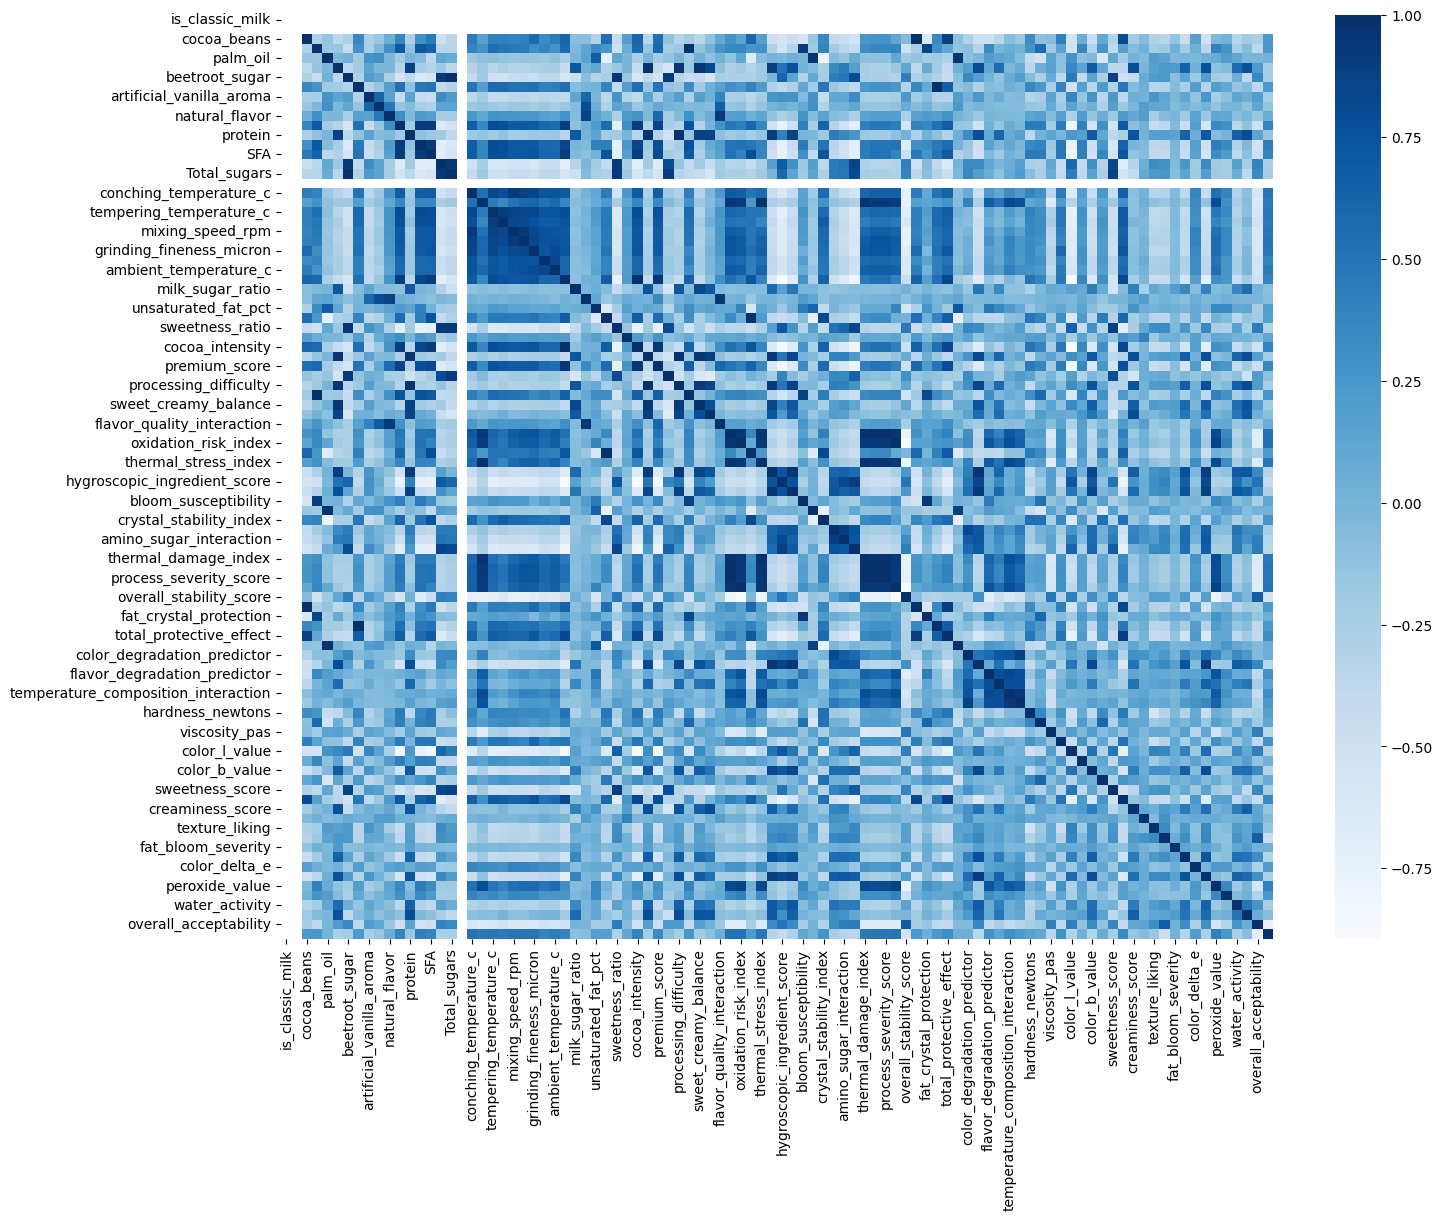

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
sns.heatmap(df_enhanced_with_targets.select_dtypes((int,float)).corr(), cmap='Blues')